In [ ]:
#required package
!pip install transformers datasets torch scikit-learn

In [24]:
#import Required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
from datasets import Dataset
from transformers import BertTokenizer,BertForSequenceClassification,Trainer, TrainingArguments,BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report
from transformers.trainer_callback import EarlyStoppingCallback
import torch
import logging

In [25]:
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('training.log')
    ]
)
logger = logging.getLogger(__name__)

In [ ]:
#Read Dataset
df=pd.read_csv("ecom_product_review.csv")

In [27]:
df #dataset

,label,text
0,__label__2,Metalwork for Craftsmen: I found this book ful...
1,__label__2,Great DVD: Bought this for my 3 year old grand...
2,__label__2,A gifted musical singer with a finely honed ja...
3,__label__2,"Spring is ""MAGICAL!"": It was early spring of 1..."
4,__label__2,"it's good, oh it's darn good: Kurt Angle tells..."
...,...,...
24995,__label__1,Don't do it!!: The high chair looks great when...
24996,__label__1,"Looks nice, low functionality: I have used thi..."
24997,__label__1,"compact, but hard to clean: We have a small ho..."
24998,__label__1,what is it saying?: not sure what this book is...


In [28]:
df.head() #top 5 rows

,label,text
0,__label__2,Metalwork for Craftsmen: I found this book ful...
1,__label__2,Great DVD: Bought this for my 3 year old grand...
2,__label__2,A gifted musical singer with a finely honed ja...
3,__label__2,"Spring is ""MAGICAL!"": It was early spring of 1..."
4,__label__2,"it's good, oh it's darn good: Kurt Angle tells..."


In [29]:
df.tail() #Last 5 rows

,label,text
24995,__label__1,Don't do it!!: The high chair looks great when...
24996,__label__1,"Looks nice, low functionality: I have used thi..."
24997,__label__1,"compact, but hard to clean: We have a small ho..."
24998,__label__1,what is it saying?: not sure what this book is...
24999,__label__2,Makes My Blood Run Red-White-And-Blue: I agree...


In [30]:
df.info() #information about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   25000 non-null  object
 1   text    25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [31]:
df.isnull().sum() #check the null value

label    0
text     0
dtype: int64

In [32]:
df.duplicated().sum() #duplicate remove

0

In [33]:
df['label'].value_counts() #label count

label
__label__2    12500
__label__1    12500
Name: count, dtype: int64

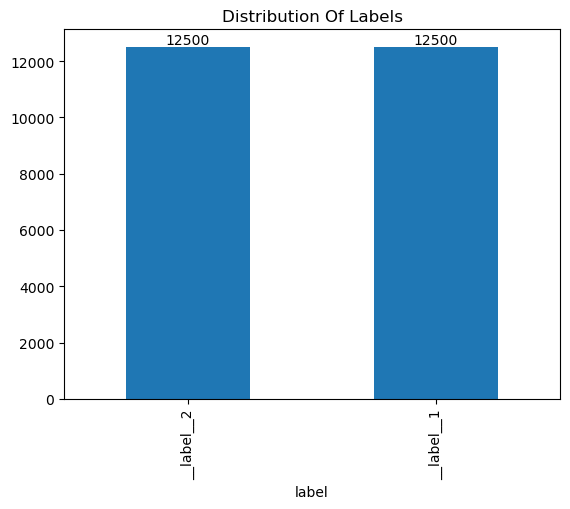

In [34]:
#Distribution of labels
data=df['label'].value_counts()
ax=data.plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.title("Distribution Of Labels")
plt.show()

In [35]:
df['text'][0] #In dataset text col first row

'Metalwork for Craftsmen: I found this book full of helpful information, and easy to read. A must have for anyone interested in metal craft.'

In [36]:
#Apply Preprocess Step On That
def clean_text(text):
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags

    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace

    text = text.lower() #lowercase

    return text


df['text'] = df['text'].apply(clean_text)

In [37]:
df['text'][5555]

"i'm glad i brought it: i love the instruction and the drum beats. i especially like the healing dance it allows me to let go of daily stress and come back to self. strange how the sounds of africa bring out the movements of my soul. i am malian american and give respect to my ancestors who dance the same dance with vigor and spirit. much love"

In [38]:
# If your labels are __label__1 and __label__2
def convert_label(label):
    return 1 if label == '__label__1' else 0  # 1: churn/negative, 0: not churn/positive

In [39]:
df['label'] = df['label'].apply(convert_label)

In [40]:
df

,label,text
0,0,metalwork for craftsmen: i found this book ful...
1,0,great dvd: bought this for my 3 year old grand...
2,0,a gifted musical singer with a finely honed ja...
3,0,"spring is ""magical!"": it was early spring of 1..."
4,0,"it's good, oh it's darn good: kurt angle tells..."
...,...,...
24995,1,don't do it!!: the high chair looks great when...
24996,1,"looks nice, low functionality: i have used thi..."
24997,1,"compact, but hard to clean: we have a small ho..."
24998,1,what is it saying?: not sure what this book is...


In [41]:
#train and test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [42]:
train_df.shape

(20000, 2)

In [43]:
test_df.shape

(5000, 2)

In [ ]:
#convert the dataset into huggingface format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

#bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

#Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [48]:
#load the bert model with number of classes and dropout
num_labels = len(df['label'].unique())
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    hidden_dropout_prob=0.15,  
    attention_probs_dropout_prob=0.15
)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
#function for classification reports
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True, target_names=['negative', 'positive'])
    logger.info(f"Classification Report:\n{report}")  # Log report
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'neg_precision': report['negative']['precision'],
        'neg_recall': report['negative']['recall'],
        'neg_f1': report['negative']['f1-score'],
        'pos_precision': report['positive']['precision'],
        'pos_recall': report['positive']['recall'],
        'pos_f1': report['positive']['f1-score']
    }

In [50]:
#define the traning arguments
training_args = TrainingArguments(
    output_dir='./results5.0',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.025,  
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy', 
    greater_is_better=True,
    learning_rate=1e-5,
    lr_scheduler_type='cosine',
    seed=42,
)

In [51]:
#Initialize trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.00001  
    )]
)

In [ ]:
#train
trainer.train()
logger.info(f"Training completed with {trainer.state.global_step} steps")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Neg Precision,Neg Recall,Neg F1,Pos Precision,Pos Recall,Pos F1
1,0.211900,0.189324,0.942400,0.942388,0.942564,0.942400,0.950867,0.931634,0.941152,0.934445,0.952927,0.943596
2,0.071800,0.196725,0.947800,0.947801,0.947820,0.947800,0.944511,0.950243,0.947368,0.951055,0.945411,0.948225


In [ ]:
!pip install datasets numpy --upgrade #sometimes after run this train give numpy error then run this cell.

In [ ]:
#Evaluate
eval_results = trainer.evaluate()
logger.info(f"Final Evaluation Results: {eval_results}")
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.1967254877090454, 'eval_accuracy': 0.9478, 'eval_f1': 0.9478012842063499, 'eval_precision': 0.9478196291707729, 'eval_recall': 0.9478, 'eval_neg_precision': 0.9445114595898673, 'eval_neg_recall': 0.9502427184466019, 'eval_neg_f1': 0.9473684210526315, 'eval_pos_precision': 0.9510545165141265, 'eval_pos_recall': 0.9454113924050633, 'eval_pos_f1': 0.9482245586193215, 'eval_runtime': 35.9072, 'eval_samples_per_second': 139.248, 'eval_steps_per_second': 8.717, 'epoch': 2.0}


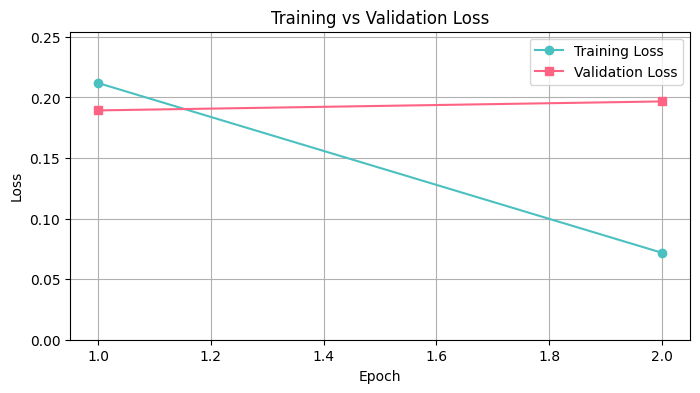

In [ ]:
#visualize the trainin and validation loss
epochs = [1, 2]
training_loss = [0.211900, 0.071800]
validation_loss = [0.189324, 0.196725]

# Create the line plot
plt.figure(figsize=(8, 4))
plt.plot(epochs, training_loss, label='Training Loss', color='#4BC0C0', marker='o')  # Cyan
plt.plot(epochs, validation_loss, label='Validation Loss', color='#FF6384', marker='s')  # Red

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, max(max(training_loss), max(validation_loss)) * 1.2)  # Start y-axis at 0

# Save and show the plot
plt.savefig('training_validation_loss.png')
plt.show()

In [ ]:
#save the model
model.save_pretrained('./bert_model')
tokenizer.save_pretrained('./bert_model')

('./bert_model/tokenizer_config.json',
 './bert_model/special_tokens_map.json',
 './bert_model/vocab.txt',
 './bert_model/added_tokens.json')

In [1]:
#inference
from transformers import pipeline

classifier = pipeline('text-classification', model='./bert_model', tokenizer='./bert_model')
text = "I was a bit skeptical at first, but this product turned out to be amazing. It works exactly as described and the quality is top-notch. Totally worth the money!"
prediction = classifier(text)
print(f"Text: {text}\nPrediction: {prediction}")

Device set to use cpu


Text: I was a bit skeptical at first, but this product turned out to be amazing. It works exactly as described and the quality is top-notch. Totally worth the money!
Prediction: [{'label': 'LABEL_0', 'score': 0.9982770681381226}]
